In [1]:
import tensorflow as tf
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
# Q3 API
from layers import dense 

In [4]:
epochs = 35
batch_size = 200
learning_rate = 0.3

In [5]:
mnist = np.load('mnist.npz')

In [6]:
# split training data (60,000) into 55,000 for train and 5,000 for validate images
train, x_test = mnist['x_train'], mnist['x_test']
train = train.reshape((60000, 784))/255
x_train = train[:55000].copy()
x_val = train[55000:].copy()
x_test = x_test.reshape((10000, 784))/255
# labels
train_labels = mnist['y_train']
y_train = np.eye(10)[train_labels[:55000]]
y_val = np.eye(10)[train_labels[55000:]]
y_test = np.eye(10)[mnist['y_test']]

In [7]:
# input
x_p = tf.placeholder(tf.float32, [None, 784])
# output
y_p = tf.placeholder(tf.float32, [None, 10])

In [8]:
hidden1 = dense(x=x_p, in_length=784, neurons=300, activation=tf.nn.relu, layer_name='Layer_1', dev=0.01)
hidden2 = dense(x=hidden1, in_length=300, neurons=100, activation=tf.nn.relu, layer_name='Layer_2', dev=0.01)
output = dense(x=hidden2, in_length=100, neurons=10, activation=tf.nn.softmax, layer_name='Layer_Output')
y_clipped = tf.clip_by_value(output, 1e-10, 0.9999999)
cross_entropy = -tf.reduce_mean(tf.reduce_sum(y_p * tf.log(y_clipped)+ (1 - y_p) * tf.log(1 - y_clipped), axis=1))
optimiser = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cross_entropy)

In [9]:
labels = tf.argmax(y_p, 1)
predictions = tf.argmax(output, 1)

In [10]:
acc, acc_op = tf.metrics.accuracy(labels, predictions)

In [11]:
conmat = tf.confusion_matrix(labels, predictions)

In [12]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    avg_loss = []
    validate_accuracy = []
    total_batches = x_train.shape[0] // batch_size
    
    # Training
    for e in range(epochs):
        avg_loss.append(0.0)
        for b in range(total_batches):
            start = b*batch_size
            end = (b+1)*batch_size
            batch = sess.run([optimiser, cross_entropy], 
                     feed_dict={x_p: x_train[start:end], y_p: y_train[start:end]})
            avg_loss[e] += batch[1] / total_batches
        
        # Validation
        accuracy = sess.run(acc_op,
                 feed_dict={x_p: x_val, y_p: y_val})
        validate_accuracy.append(accuracy)
        print("Epoch: {:2d}".format(e + 1), "train_loss =", "{:.4f}".format(avg_loss[e]), "validate_accuracy =", "{:.4f}".format(validate_accuracy[e]))
        
    # Testing
    test_accuracy, confusion_mat = sess.run([acc_op, conmat],
                    feed_dict={x_p:x_test, y_p:y_test})
    
    print('Testing Accuracy:', test_accuracy)
    print('Confusion Matrix:', confusion_mat)
    
    tf.io.write_graph(sess.graph_def, 'graphs/', 'mnist-v1.pbtxt')    

Epoch:  1 train_loss = 1.1686 validate_accuracy = 0.9400
Epoch:  2 train_loss = 0.3525 validate_accuracy = 0.9528
Epoch:  3 train_loss = 0.2399 validate_accuracy = 0.9575
Epoch:  4 train_loss = 0.1832 validate_accuracy = 0.9607
Epoch:  5 train_loss = 0.1543 validate_accuracy = 0.9631
Epoch:  6 train_loss = 0.1225 validate_accuracy = 0.9647
Epoch:  7 train_loss = 0.1018 validate_accuracy = 0.9660
Epoch:  8 train_loss = 0.0853 validate_accuracy = 0.9669
Epoch:  9 train_loss = 0.0735 validate_accuracy = 0.9676
Epoch: 10 train_loss = 0.0654 validate_accuracy = 0.9682
Epoch: 11 train_loss = 0.0543 validate_accuracy = 0.9686
Epoch: 12 train_loss = 0.0519 validate_accuracy = 0.9690
Epoch: 13 train_loss = 0.0437 validate_accuracy = 0.9694
Epoch: 14 train_loss = 0.0397 validate_accuracy = 0.9699
Epoch: 15 train_loss = 0.0323 validate_accuracy = 0.9702
Epoch: 16 train_loss = 0.0309 validate_accuracy = 0.9704
Epoch: 17 train_loss = 0.0275 validate_accuracy = 0.9707
Epoch: 18 train_loss = 0.0239 v

In [13]:
np.savetxt('mnistv1-conmat.txt', confusion_mat, fmt='%4d', delimiter=' & ', newline='\\\\\ \hline\n')

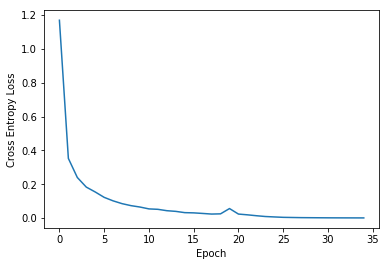

In [14]:
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.plot(avg_loss[None:])
plt.show()

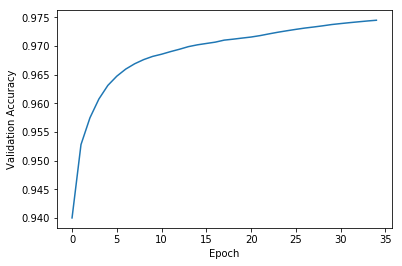

In [15]:
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.plot(validate_accuracy)
plt.show()

In [16]:
True_positives = np.diag(confusion_mat)
False_positives = np.sum(confusion_mat, axis=1) - True_positives
False_negatives = np.sum(confusion_mat, axis=0) - True_positives
Precision = True_positives / (True_positives + False_positives)
print("Precision:", Precision)
Recall = True_positives / (True_positives + False_negatives)
print("\nRecall:", Recall)
F_scores = (2*Precision*Recall) / (Recall+Precision)
print("\nF_scores:", F_scores)

Precision: [0.9877551  0.99207048 0.97674419 0.98316832 0.97454175 0.97533632
 0.98121086 0.97859922 0.97433265 0.97720515]

Recall: [0.98373984 0.99294533 0.984375   0.97448479 0.98355601 0.97862767
 0.9832636  0.9776482  0.97333333 0.96951819]

F_scores: [0.98574338 0.99250771 0.98054475 0.97880729 0.97902813 0.97697923
 0.98223615 0.97812348 0.97383273 0.9733465 ]


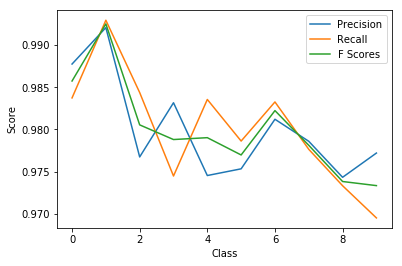

In [17]:
plt.plot(Precision, label='Precision')
plt.plot(Recall, label='Recall')
plt.plot(F_scores, label='F Scores')
plt.ylabel('Score')
plt.xlabel('Class')
plt.legend()
plt.show()